## Load and look at the time series data

In [2]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
np.random.seed(1)

# load the data
#Adjusted close price is the closing price after adjustments for all applicable splits and dividend distributions
AAPL_prices = pd.read_csv("AAPL.csv", usecols=["Adj Close"]) 
AAPL_returns = np.log(AAPL_prices['Adj Close']).diff()[1:] # delete the first row which is nan
SPWR_prices = pd.read_csv("SPWR.csv", usecols=["Adj Close"]) 
SPWR_returns = np.log(SPWR_prices['Adj Close']).diff()[1:] # delete the first row which is nan
SP500_prices = pd.read_csv("SP500.mst", usecols=["<CLOSE>"])[7582:] # select data after 2000-01-03
SP500_prices.reset_index(drop=True, inplace=True)
SP500_returns = np.log(SP500_prices['<CLOSE>']).diff()[1:] # delete the first row which is nan

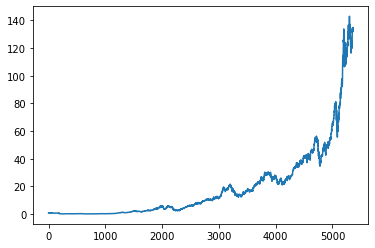

In [3]:
plt.plot(AAPL_prices)

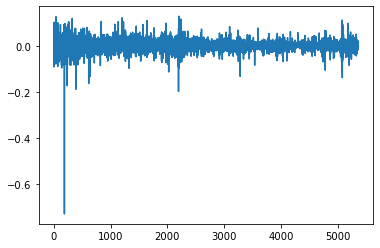

In [4]:
plt.plot(AAPL_returns)

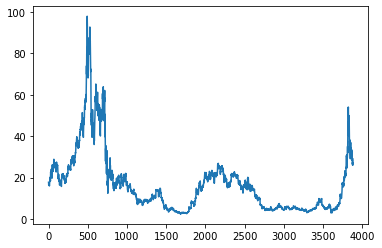

In [5]:
plt.plot(SPWR_prices)

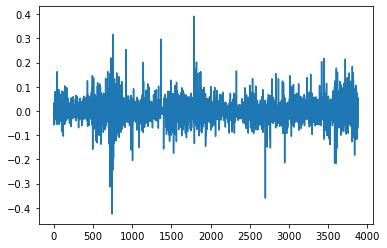

In [6]:
plt.plot(SPWR_returns)

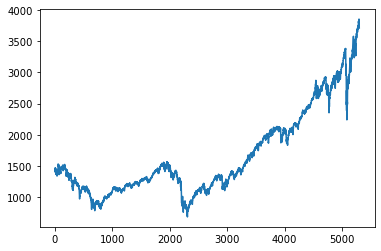

In [7]:
plt.plot(SP500_prices)

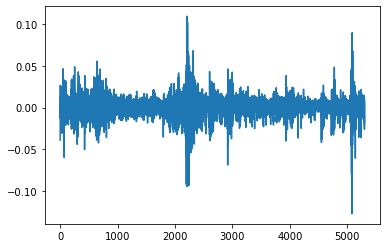

In [8]:
plt.plot(SP500_returns)

## Environments

In [9]:
# actions
buy = 1
sell = -1
actions = [buy, sell]

def random_policy(actions):
    return np.random.choice(actions)

def epsilon_greedy_policy(epsilon, actions, values):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        argmax = np.argmax(values)
        return actions[argmax]

# The environment uses daily returns as rewards
class TradingSystemwithReturnasReward:
    def __init__(self, stock_returns, k_value, initial_investment):
        self.initial_investment = initial_investment
        self.capital = self.initial_investment
        self.k = k_value
        self.r_ts = stock_returns
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.initial_state = tuple(self.r_ts[:self.k].tolist()+[random_policy(actions)]) # Use tuple because it's immutable
        self.state = self.initial_state
        self.reward = 0.0
        self.daily_returns = []
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
             self.is_terminal = True
        gainOrloss = self.capital*action*self.r_ts[self.current_step+self.k-1]
        obtained_return = action*self.r_ts[self.current_step+self.k-1]
        self.capital += gainOrloss
        self.daily_returns.append(gainOrloss)
        self.reward = obtained_return
        self.state = tuple(self.r_ts[self.current_step:(self.k+self.current_step)].tolist()+[action])
        return self.state, self.reward, self.is_terminal

    def get_profit(self):
        return self.capital - self.initial_investment
    
    def get_daily_returns(self):
        return self.daily_returns
    
    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.daily_returns = []
        self.current_step = 0
        self.capital = self.initial_investment
        self.is_terminal = False
        return self.state


In [10]:
# The environment uses differential Sharpe Ratio as rewards
class TradingSystemwithDSRasReward:
    def __init__(self, stock_returns, k_value, eta, initial_investment):
        self.initial_investment = initial_investment
        self.capital = self.initial_investment
        self.k = k_value
        self.eta = eta
        self.r_ts = stock_returns
        self.total_steps = len(self.r_ts) - self.k
        self.current_step = 0
        self.initial_state = tuple(self.r_ts[:self.k].tolist()+[random_policy(actions)]) # Use tuple because it's immutable
        self.state = self.initial_state
        self.reward = 0.0
        self.daily_returns = []
        self.at = 0.0
        self.bt = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        self.current_step += 1
        if self.current_step == self.total_steps:
             self.is_terminal = True
        gainOrloss = self.capital*action*self.r_ts[self.current_step+self.k-1]
        obtained_return = action*self.r_ts[self.current_step+self.k-1]
        self.capital += gainOrloss
        self.daily_returns.append(gainOrloss)
        delta_at =  obtained_return - self.at
        delta_bt =  obtained_return**2 - self.bt
        numerator = self.bt*delta_at - 0.5*self.at*delta_bt
        denominator = (self.bt - self.at**2)**1.5
        if denominator == 0:
            self.reward = obtained_return
        else:
            self.reward = numerator/denominator
        self.at += self.eta*delta_at
        self.bt += self.eta*delta_bt
        self.state = tuple(self.r_ts[self.current_step:(self.k+self.current_step)].tolist()+[action])
        return self.state, self.reward, self.is_terminal

    def get_profit(self):
        return self.capital - self.initial_investment
    
    def get_daily_returns(self):
        return self.daily_returns
    
    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.daily_returns = []
        self.current_step = 0
        self.capital = self.initial_investment
        self.at = 0.0
        self.bt = 0.0
        self.is_terminal = False
        return self.state


## Approximators

In [11]:
# This approximator uses discounted setting
class DiscountedApproximator:
    def __init__(self, dim, n_a, alpha, discount):
        self.__discount = discount
        self.__alpha = alpha
        self.__n_actions = n_a
        self.__feature_dim = dim
        self.__w_size = self.__feature_dim + 1 # add the bias term
        self.__w = np.zeros(self.__w_size)

    def get_w(self):
        return self.__w
    
    def reset(self):
        self.__w = np.zeros(self.__w_size)

    def squashing_f(self, x):
        a = 2
        b = 1
        c = 10**15
        d = -1
        return a/(math.exp(-c*x)*b+1)-d
    
    
    def feature_transformation(self, state, a):
        features = np.array([1] + list(state) + [a])
        return features

    # linear_features
    def action_value_estimator(self, features):
        return np.inner(features, self.__w)

    # minimising MSE between q(replaced by td target) and q_hat
    def update_w(self, r, q, next_q, features):
        target = r + self.__discount * next_q
        td_error = target - q
        w_gradient = self.__alpha * td_error * features
        self.__w = self.__w + w_gradient
    

    def cost_to_go(self, state):
        features = self.feature_transformation(state)
        v_s = []
        for i in range(self.__n_actions):
            v_s.append(self.action_value_estimator(features, i))
        return - np.max(v_s)


In [12]:
# This approximator uses average-reward setting
class ContinuingApproximator:
    def __init__(self, dim, n_a, alpha, beta):
        self.__alpha = alpha
        self.__beta = beta
        self.__n_actions = n_a
        self.__feature_dim = dim
        self.__average_reward = 0
        self.__w_size = self.__feature_dim + 1 # add the bias term
        self.__w = np.zeros(self.__w_size)

    def get_w(self):
        return self.__w
    
    def reset(self):
        self.__w = np.zeros(self.__w_size)
        self.__average_reward = 0

    def feature_transformation(self, state, a):
        features = np.array([1] + list(state) + [a])
        return features

    # linear_features
    def action_value_estimator(self, features):
        return np.inner(features, self.__w)

    # minimising MSE between q(replaced by td target) and q_hat
    def update_w(self, r, q, next_q, features):
        target = r - self.__average_reward + next_q
        td_error = target - q
        self.__average_reward += self.__beta*td_error
        w_gradient = self.__alpha * td_error * features
        self.__w = self.__w + w_gradient

    def cost_to_go(self, state):
        features = self.feature_transformation(state)
        v_s = []
        for i in range(self.__n_actions):
            v_s.append(self.action_value_estimator(features, i))
        return - np.max(v_s)
    


## SARSA and Q-learning algorithms

In [13]:
#SARSA algorithm
def SARSA(env, actions, epsilon, estimator):
    state = env.reset()
    estimator.reset()
    a = random_policy(actions)
    action_list = []
    while True:
        next_state, r, done= env.step(a) 
        action_list.append(a)
        if done:
            break
        # compute q_sa
        features = estimator.feature_transformation(state, a)
        q_sa = estimator.action_value_estimator(features)

        # compute all actions in the next state for optimal policy
        q_values = []
        for j in actions:
            next_feature = estimator.feature_transformation(next_state, j)
            q_values.append(estimator.action_value_estimator(next_feature))

        next_a = epsilon_greedy_policy(epsilon, actions, q_values)
        # SARSA updates the action-value using the value of the action generated from the policy
        next_q_sa = q_values[actions.index(next_a)]

        # update weights for current action
        estimator.update_w(r, q_sa, next_q_sa, features)
        a = next_a
        state = next_state
        
    final_profit = env.get_profit()
    dr = env.get_daily_returns()
    positive_pc = len([i for i in dr if i > 0])/len(dr)
    weights = estimator.get_w()
    return final_profit, dr, weights, positive_pc, action_list



# Q-learning algorithm
def Q_learning(env, actions, epsilon, estimator):
    state = env.reset()
    estimator.reset()
    a = random_policy(actions)
    action_list = []
    while True:
        next_state, r, done= env.step(a)
        action_list.append(a)
        if done:
            break
        # compute q_sa
        features = estimator.feature_transformation(state, a)
        q_sa = estimator.action_value_estimator(features)

        # compute all actions in the next state for optimal policy
        q_values = []
        for j in actions:
            next_feature = estimator.feature_transformation(next_state, j)
            q_values.append(estimator.action_value_estimator(next_feature))

        next_a = epsilon_greedy_policy(epsilon, actions, q_values)
        # q-learning updates the action-value using the value of the action maximizing it
        next_q_sa = np.max(q_values)

        # update weights for current action
        estimator.update_w(r, q_sa, next_q_sa, features)
        a = next_a
        state = next_state
        
    final_profit = env.get_profit()
    dr = env.get_daily_returns()
    positive_pc = len([i for i in dr if i > 0])/len(dr)
    weights = estimator.get_w()
    return final_profit, dr, weights, positive_pc, action_list

## Test with different settings and stocks

Final profit for SARSA:  215405.84016279274
Final profit for Q-Learning:  11789.706958728202
Percentage of days with positive returns for SARSA:  0.5180205415499534
Percentage of days with positive returns for Q-Learning:  0.5243697478991597


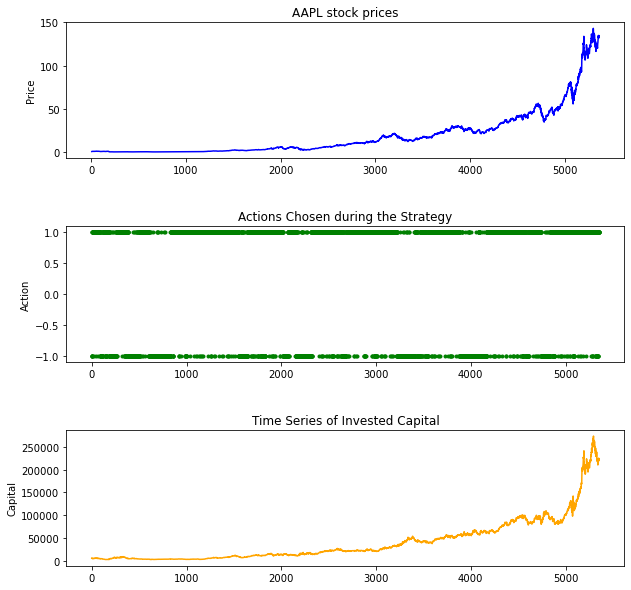

In [14]:
# Discounted Setting with Daily Return as reward
# Parameters
K = 5
eta = 0.05
initial_investment = 5000
n_actions = len(actions)
alpha = 0.05
gamma = 0.95
epsilon = 0.1
dim = K + 2
env = TradingSystemwithReturnasReward(AAPL_returns, K, initial_investment)
estimator = DiscountedApproximator(dim, n_actions, alpha, gamma)

profit_s, dr_s, weights_s, pc_s, alist_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q, pc_q, alist_q = Q_learning(env, actions, epsilon, estimator)
capital_series_sarsa = initial_investment + np.cumsum(dr_s)
capital_series_qlearning = initial_investment + np.cumsum(dr_q)

print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)
print("Percentage of days with positive returns for SARSA: ", pc_s)
print("Percentage of days with positive returns for Q-Learning: ", pc_q)

# plotting
fig = plt.figure(figsize=(10, 10)) 
ax1 = fig.add_subplot(311)
ax1.set_title('AAPL stock prices')
ax1.plot(AAPL_prices[(K+2):],  color='blue')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(312)
ax2.set_title('Actions Chosen during the Strategy')
ax2.plot(alist_s, '.', color='green')
ax2.set_ylabel('Action')

ax3 = fig.add_subplot(313)
ax3.set_title('Time Series of Invested Capital')
ax3.plot(capital_series_sarsa, color='orange')
ax3.set_ylabel('Capital')
plt.subplots_adjust(hspace=0.5)
plt.savefig('figure1.png')
plt.show()

In [15]:
weights_s

array([ 0.02197161, -0.00323173,  0.00158637, -0.00689013, -0.00175515,
        0.00795352,  0.00144482,  0.00334068])

Final profit for SARSA:  -4900.592853461845
Final profit for Q-Learning:  -4971.624509801553
Percentage of days with positive returns for SARSA:  0.49458204334365324
Percentage of days with positive returns for Q-Learning:  0.49019607843137253


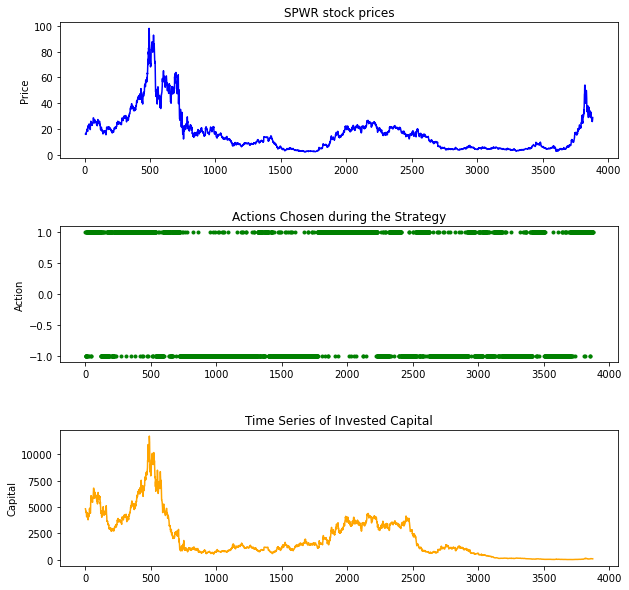

In [16]:
# Discounted Setting with Daily Return as reward
# Parameters
K = 5
eta = 0.05
initial_investment = 5000
n_actions = len(actions)
alpha = 0.05
gamma = 0.95
epsilon = 0.1
dim = K + 2
env = TradingSystemwithReturnasReward(SPWR_returns, K, initial_investment)
estimator = DiscountedApproximator(dim, n_actions, alpha, gamma)

profit_s, dr_s, weights_s, pc_s, alist_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q, pc_q, alist_q = Q_learning(env, actions, epsilon, estimator)
capital_series_sarsa = initial_investment + np.cumsum(dr_s)
capital_series_qlearning = initial_investment + np.cumsum(dr_q)

print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)
print("Percentage of days with positive returns for SARSA: ", pc_s)
print("Percentage of days with positive returns for Q-Learning: ", pc_q)

# plotting
fig = plt.figure(figsize=(10, 10)) 
ax1 = fig.add_subplot(311)
ax1.set_title('SPWR stock prices')
ax1.plot(SPWR_prices[(K+2):],  color='blue')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(312)
ax2.set_title('Actions Chosen during the Strategy')
ax2.plot(alist_s, '.', color='green')
ax2.set_ylabel('Action')

ax3 = fig.add_subplot(313)
ax3.set_title('Time Series of Invested Capital')
ax3.plot(capital_series_sarsa, color='orange')
ax3.set_ylabel('Capital')
plt.subplots_adjust(hspace=0.5)
plt.savefig('figure2.png')
plt.show()

In [16]:
weights_s

array([-0.00315142,  0.00115413,  0.01210639,  0.0077866 ,  0.0108612 ,
       -0.06877206,  0.0147975 ,  0.02910601])

Final profit for SARSA:  258.8491904265802
Final profit for Q-Learning:  2919.4733600398486
Percentage of days with positive returns for SARSA:  0.532666163141994
Percentage of days with positive returns for Q-Learning:  0.5254909365558912


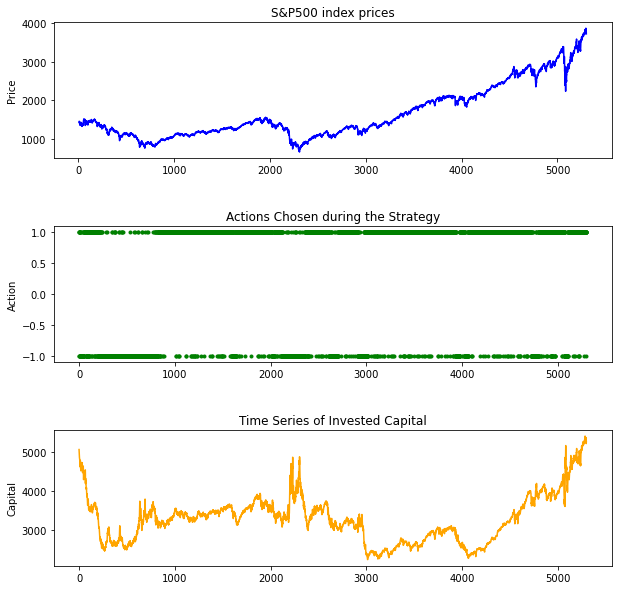

In [17]:
# Discounted Setting with Daily Return as reward
# Parameters
K = 5
eta = 0.05
initial_investment = 5000
n_actions = len(actions)
alpha = 0.05
gamma = 0.95
epsilon = 0.1
dim = K + 2
env = TradingSystemwithReturnasReward(SP500_returns, K, initial_investment)
estimator = DiscountedApproximator(dim, n_actions, alpha, gamma)

profit_s, dr_s, weights_s, pc_s, alist_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q, pc_q, alist_q = Q_learning(env, actions, epsilon, estimator)
capital_series_sarsa = initial_investment + np.cumsum(dr_s)
capital_series_qlearning = initial_investment + np.cumsum(dr_q)

print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)
print("Percentage of days with positive returns for SARSA: ", pc_s)
print("Percentage of days with positive returns for Q-Learning: ", pc_q)

# plotting
fig = plt.figure(figsize=(10, 10)) 
ax1 = fig.add_subplot(311)
ax1.set_title('S&P500 index prices')
ax1.plot(SP500_prices[(K+2):],  color='blue')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(312)
ax2.set_title('Actions Chosen during the Strategy')
ax2.plot(alist_s, '.', color='green')
ax2.set_ylabel('Action')

ax3 = fig.add_subplot(313)
ax3.set_title('Time Series of Invested Capital')
ax3.plot(capital_series_sarsa, color='orange')
ax3.set_ylabel('Capital')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [18]:
weights_s

array([ 1.07089780e-02,  1.23283830e-05, -6.06209007e-05, -2.91428810e-04,
        2.71274190e-03, -1.08516438e-02, -1.53447607e-03,  4.62947540e-03])

In [19]:
# Discounted Setting with Differetial Sharpe Ratio as reward
# Parameters
K = 5
eta = 0.05
initial_investment = 5000
n_actions = len(actions)
alpha = 0.05
gamma = 0.95
epsilon = 0.1
dim = K + 2
env =TradingSystemwithDSRasReward(SPWR_returns, K, eta, initial_investment)
estimator = DiscountedApproximator(dim, n_actions, alpha, gamma)

profit_s, dr_s, weights_s, pc_s, alist_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q, pc_q, alist_q = Q_learning(env, actions, epsilon, estimator)



print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)
print("Percentage of days with positive returns for SARSA: ", pc_s)
print("Percentage of days with positive returns for Q-Learning: ", pc_q)

Final profit for SARSA:  -4376.571261142579
Final profit for Q-Learning:  19336.05639279017
Percentage of days with positive returns for SARSA:  0.49638802889576883
Percentage of days with positive returns for Q-Learning:  0.5043859649122807


In [20]:
weights_s

array([ 0.08876513,  0.04794399,  0.10320876,  0.15153315,  0.21096044,
       -0.94512863,  0.0632272 , -0.08670499])

In [21]:
# Average-reward Setting with Daily Return as reward
# Parameters
K = 5
eta = 0.05
initial_investment = 5000
n_actions = len(actions)
alpha = 0.05
beta = 0.05
epsilon = 0.1
dim = K + 2
env = TradingSystemwithReturnasReward(AAPL_returns, K, initial_investment)
estimator = ContinuingApproximator(dim, n_actions, alpha, beta)

profit_s, dr_s, weights_s, pc_s, alist_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q, pc_q, alist_q = Q_learning(env, actions, epsilon, estimator)


print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)
print("Percentage of days with positive returns for SARSA: ", pc_s)
print("Percentage of days with positive returns for Q-Learning: ", pc_q)

Final profit for SARSA:  10084.466287053909
Final profit for Q-Learning:  19585.013180362188
Percentage of days with positive returns for SARSA:  0.5092436974789916
Percentage of days with positive returns for Q-Learning:  0.5144724556489262


In [22]:
weights_s

array([ 0.00017141,  0.00114262,  0.00195638,  0.00487007,  0.00843898,
       -0.03594553, -0.00242934, -0.00035862])

In [23]:
# Average-reward Setting with Differetial Sharpe Ratio as reward
# Parameters
K = 5
eta = 0.05
initial_investment = 5000
n_actions = len(actions)
alpha = 0.05
beta = 0.05
epsilon = 0.1
dim = K + 2
env =TradingSystemwithDSRasReward(AAPL_returns, K, eta, initial_investment)
estimator = ContinuingApproximator(dim, n_actions, alpha, beta)

profit_s, dr_s, weights_s, pc_s, alist_s = SARSA(env, actions, epsilon, estimator)
profit_q, dr_q, weights_q, pc_q, alist_q = Q_learning(env, actions, epsilon, estimator)


print("Final profit for SARSA: ", profit_s)
print("Final profit for Q-Learning: ", profit_q)
print("Percentage of days with positive returns for SARSA: ", pc_s)
print("Percentage of days with positive returns for Q-Learning: ", pc_q)

Final profit for SARSA:  -4925.200329608875
Final profit for Q-Learning:  -2205.420764782208
Percentage of days with positive returns for SARSA:  0.49094304388422033
Percentage of days with positive returns for Q-Learning:  0.507563025210084


In [24]:
weights_s

array([ 0.03677059,  0.08797961, -0.01012685,  0.06049022,  0.25898924,
       -1.04107981, -0.04432399, -0.09899553])

## Simulation Result

In [25]:
# Simulation with AAPL stock
stock_returns = AAPL_returns
simulation = 100
K_range = list(range(1, 6))
eta = 0.05
initial_investment = 1
n_actions = len(actions)
alpha = 0.05
beta = 0.05
gamma = 0.95
epsilon = 0.1
AAPL_table = np.zeros((8, 5, len(K_range)))
for k in K_range:
    env_r = TradingSystemwithReturnasReward(stock_returns, k, initial_investment)
    env_dsr =TradingSystemwithDSRasReward(stock_returns, k, eta, initial_investment)
    dim = k + 2
    estimator_d = DiscountedApproximator(dim, n_actions, alpha, gamma)
    estimator_c = ContinuingApproximator(dim, n_actions, alpha, beta)
    all_profits = np.zeros((simulation, 8))
    all_pc = np.zeros((simulation, 8))
    for i in range(simulation):
        np.random.seed(i)
        profit, _, _, pc, _= SARSA(env_r, actions, epsilon, estimator_d)
        all_profits[i, 0] = profit
        all_pc[i, 0] = pc
        profit, _, _, pc, _= Q_learning(env_r, actions, epsilon, estimator_d)
        all_profits[i, 1] = profit
        all_pc[i, 1] = pc
        profit, _, _, pc, _ = SARSA(env_r, actions, epsilon, estimator_c)
        all_profits[i, 2] = profit
        all_pc[i, 2] = pc
        profit, _, _, pc, _ = Q_learning(env_r, actions, epsilon, estimator_c)
        all_profits[i, 3] = profit
        all_pc[i, 3] = pc
        profit, _, _, pc, _= SARSA(env_dsr, actions, epsilon, estimator_d)
        all_profits[i, 4] = profit
        all_pc[i, 4] = pc
        profit, _, _, pc, _ = Q_learning(env_dsr, actions, epsilon, estimator_d)
        all_profits[i, 5] = profit
        all_pc[i, 5] = pc
        profit, _, _, pc, _= SARSA(env_dsr, actions, epsilon, estimator_c)
        all_profits[i, 6] = profit
        all_pc[i, 6] = pc
        profit, _, _, pc, _= Q_learning(env_dsr, actions, epsilon, estimator_c)
        all_profits[i, 7] = profit
        all_pc[i, 7] = pc
        print("K = ", k, " ,  Simulation ", i+1)
        
    AAPL_table[:, 0, k-1] = all_profits.mean(axis=0)
    AAPL_table[:, 1, k-1]= all_profits.std(axis=0)
    VaR = np.quantile(all_profits, 0.05, axis=0, interpolation="lower")
    ES = np.zeros(8)
    for j in range(8):
        col = all_profits[:, j].flatten()
        es_j = col[col <= VaR[j]].mean()
        ES[j] = es_j
    AAPL_table[:, 2, k-1] = VaR
    AAPL_table[:, 3, k-1]= ES
    AAPL_table[:, 4, k-1] = all_pc.mean(axis=0)

K =  1  ,  Simulation  1
K =  1  ,  Simulation  2
K =  1  ,  Simulation  3
K =  1  ,  Simulation  4
K =  1  ,  Simulation  5
K =  1  ,  Simulation  6
K =  1  ,  Simulation  7
K =  1  ,  Simulation  8
K =  1  ,  Simulation  9
K =  1  ,  Simulation  10
K =  1  ,  Simulation  11
K =  1  ,  Simulation  12
K =  1  ,  Simulation  13
K =  1  ,  Simulation  14
K =  1  ,  Simulation  15
K =  1  ,  Simulation  16
K =  1  ,  Simulation  17
K =  1  ,  Simulation  18
K =  1  ,  Simulation  19
K =  1  ,  Simulation  20
K =  1  ,  Simulation  21
K =  1  ,  Simulation  22
K =  1  ,  Simulation  23
K =  1  ,  Simulation  24
K =  1  ,  Simulation  25
K =  1  ,  Simulation  26
K =  1  ,  Simulation  27
K =  1  ,  Simulation  28
K =  1  ,  Simulation  29
K =  1  ,  Simulation  30
K =  1  ,  Simulation  31
K =  1  ,  Simulation  32
K =  1  ,  Simulation  33
K =  1  ,  Simulation  34
K =  1  ,  Simulation  35
K =  1  ,  Simulation  36
K =  1  ,  Simulation  37
K =  1  ,  Simulation  38
K =  1  ,  Simulation

K =  4  ,  Simulation  18
K =  4  ,  Simulation  19
K =  4  ,  Simulation  20
K =  4  ,  Simulation  21
K =  4  ,  Simulation  22
K =  4  ,  Simulation  23
K =  4  ,  Simulation  24
K =  4  ,  Simulation  25
K =  4  ,  Simulation  26
K =  4  ,  Simulation  27
K =  4  ,  Simulation  28
K =  4  ,  Simulation  29
K =  4  ,  Simulation  30
K =  4  ,  Simulation  31
K =  4  ,  Simulation  32
K =  4  ,  Simulation  33
K =  4  ,  Simulation  34
K =  4  ,  Simulation  35
K =  4  ,  Simulation  36
K =  4  ,  Simulation  37
K =  4  ,  Simulation  38
K =  4  ,  Simulation  39
K =  4  ,  Simulation  40
K =  4  ,  Simulation  41
K =  4  ,  Simulation  42
K =  4  ,  Simulation  43
K =  4  ,  Simulation  44
K =  4  ,  Simulation  45
K =  4  ,  Simulation  46
K =  4  ,  Simulation  47
K =  4  ,  Simulation  48
K =  4  ,  Simulation  49
K =  4  ,  Simulation  50
K =  4  ,  Simulation  51
K =  4  ,  Simulation  52
K =  4  ,  Simulation  53
K =  4  ,  Simulation  54
K =  4  ,  Simulation  55
K =  4  ,  S

In [26]:
AAPL_table

array([[[ 4.34049678e+01,  3.98485560e+01,  5.10858853e+01,
          2.50588295e+01,  2.79841822e+01],
        [ 8.66320716e+01,  6.60738782e+01,  7.59886944e+01,
          3.08851802e+01,  4.76678047e+01],
        [-1.95928830e-01,  2.43315654e-01,  4.00680046e-02,
         -1.85053821e-01, -1.97206142e-01],
        [-2.99045434e-01, -1.51874224e-01, -4.15002661e-01,
         -4.89641211e-01, -6.74772260e-01],
        [ 5.19934689e-01,  5.19354237e-01,  5.19376517e-01,
          5.18386856e-01,  5.19303455e-01]],

       [[ 2.97909747e+01,  3.88262789e+01,  4.27773988e+01,
          3.08733077e+01,  3.21441386e+01],
        [ 4.26141324e+01,  4.44653110e+01,  9.17654036e+01,
          4.10633082e+01,  7.08736792e+01],
        [ 1.87986841e-02,  3.64606140e-01,  6.56221574e-01,
          2.35800995e-01, -4.77537217e-01],
        [-2.64839234e-01, -9.44169704e-02,  3.78332496e-01,
          1.17834117e-01, -6.83622561e-01],
        [ 5.20054115e-01,  5.20696155e-01,  5.19921598e-01,
  

In [27]:
metrics = ["Mean of final returns", "Standard error of final returns", "95% VaR", "95% ES", "Days of positive return (%)"]
columns = ["K = 1", "K = 2", "K = 3", "K = 4", "K = 5"]

In [28]:
# output the summary of the simulation results
pd1 = pd.DataFrame(AAPL_table[0, :,:])
pd1.index = metrics
pd1.columns = columns
pd2 = pd.DataFrame(AAPL_table[1, :,:])
pd2.index = metrics
pd2.columns = columns
pd3 = pd.DataFrame(AAPL_table[2, :,:])
pd3.index = metrics
pd3.columns = columns
pd4 = pd.DataFrame(AAPL_table[3, :,:])
pd4.index = metrics
pd4.columns = columns
pd5 = pd.DataFrame(AAPL_table[4, :,:])
pd5.index = metrics
pd5.columns = columns
pd6 = pd.DataFrame(AAPL_table[5, :,:])
pd6.index = metrics
pd6.columns = columns
pd7 = pd.DataFrame(AAPL_table[6, :,:])
pd7.index = metrics
pd7.columns = columns
pd8 = pd.DataFrame(AAPL_table[7, :,:])
pd8.index = metrics
pd8.columns = columns
pd1.to_csv("simulation_result/AAPL_return_d_sarsa.csv")
pd2.to_csv("simulation_result/AAPL_return_d_qlearning.csv")
pd3.to_csv("simulation_result/AAPL_return_c_sarsa.csv")
pd4.to_csv("simulation_result/AAPL_return_c_qlearning.csv")
pd5.to_csv("simulation_result/AAPL_dst_d_sarsa.csv")
pd6.to_csv("simulation_result/AAPL_dst_d_qlearning.csv")
pd7.to_csv("simulation_result/AAPL_dst_c_sarsa.csv")
pd8.to_csv("simulation_result/AAPL_dst_c_qlearning.csv")

In [32]:
# Simulation with SPWR stock
stock_returns = SPWR_returns
simulation = 100
K_range = list(range(1, 6))
eta = 0.05
initial_investment = 1
n_actions = len(actions)
alpha = 0.05
beta = 0.05
gamma = 0.95
epsilon = 0.1
SPWR_table = np.zeros((8, 5, len(K_range)))
for k in K_range:
    env_r = TradingSystemwithReturnasReward(stock_returns, k, initial_investment)
    env_dsr =TradingSystemwithDSRasReward(stock_returns, k, eta, initial_investment)
    dim = k + 2
    estimator_d = DiscountedApproximator(dim, n_actions, alpha, gamma)
    estimator_c = ContinuingApproximator(dim, n_actions, alpha, beta)
    all_profits = np.zeros((simulation, 8))
    all_pc = np.zeros((simulation, 8))
    for i in range(simulation):
        np.random.seed(i)
        profit, _, _, pc, _= SARSA(env_r, actions, epsilon, estimator_d)
        all_profits[i, 0] = profit
        all_pc[i, 0] = pc
        profit, _, _, pc, _= Q_learning(env_r, actions, epsilon, estimator_d)
        all_profits[i, 1] = profit
        all_pc[i, 1] = pc
        profit, _, _, pc, _ = SARSA(env_r, actions, epsilon, estimator_c)
        all_profits[i, 2] = profit
        all_pc[i, 2] = pc
        profit, _, _, pc, _ = Q_learning(env_r, actions, epsilon, estimator_c)
        all_profits[i, 3] = profit
        all_pc[i, 3] = pc
        profit, _, _, pc, _= SARSA(env_dsr, actions, epsilon, estimator_d)
        all_profits[i, 4] = profit
        all_pc[i, 4] = pc
        profit, _, _, pc, _ = Q_learning(env_dsr, actions, epsilon, estimator_d)
        all_profits[i, 5] = profit
        all_pc[i, 5] = pc
        profit, _, _, pc, _= SARSA(env_dsr, actions, epsilon, estimator_c)
        all_profits[i, 6] = profit
        all_pc[i, 6] = pc
        profit, _, _, pc, _= Q_learning(env_dsr, actions, epsilon, estimator_c)
        all_profits[i, 7] = profit
        all_pc[i, 7] = pc
        print("K = ", k, " ,  Simulation ", i+1)
        
    SPWR_table[:, 0, k-1] = all_profits.mean(axis=0)
    SPWR_table[:, 1, k-1]= all_profits.std(axis=0)
    VaR = np.quantile(all_profits, 0.05, axis=0, interpolation="lower")
    ES = np.zeros(8)
    for j in range(8):
        col = all_profits[:, j].flatten()
        es_j = col[col <= VaR[j]].mean()
        ES[j] = es_j
    SPWR_table[:, 2, k-1] = VaR
    SPWR_table[:, 3, k-1]= ES
    SPWR_table[:, 4, k-1] = all_pc.mean(axis=0)

K =  1  ,  Simulation  1
K =  1  ,  Simulation  2
K =  1  ,  Simulation  3
K =  1  ,  Simulation  4
K =  1  ,  Simulation  5
K =  1  ,  Simulation  6
K =  1  ,  Simulation  7
K =  1  ,  Simulation  8
K =  1  ,  Simulation  9
K =  1  ,  Simulation  10
K =  1  ,  Simulation  11
K =  1  ,  Simulation  12
K =  1  ,  Simulation  13
K =  1  ,  Simulation  14
K =  1  ,  Simulation  15
K =  1  ,  Simulation  16
K =  1  ,  Simulation  17
K =  1  ,  Simulation  18
K =  1  ,  Simulation  19
K =  1  ,  Simulation  20
K =  1  ,  Simulation  21
K =  1  ,  Simulation  22
K =  1  ,  Simulation  23
K =  1  ,  Simulation  24
K =  1  ,  Simulation  25
K =  1  ,  Simulation  26
K =  1  ,  Simulation  27
K =  1  ,  Simulation  28
K =  1  ,  Simulation  29
K =  1  ,  Simulation  30
K =  1  ,  Simulation  31
K =  1  ,  Simulation  32
K =  1  ,  Simulation  33
K =  1  ,  Simulation  34
K =  1  ,  Simulation  35
K =  1  ,  Simulation  36
K =  1  ,  Simulation  37
K =  1  ,  Simulation  38
K =  1  ,  Simulation

K =  4  ,  Simulation  18
K =  4  ,  Simulation  19
K =  4  ,  Simulation  20
K =  4  ,  Simulation  21
K =  4  ,  Simulation  22
K =  4  ,  Simulation  23
K =  4  ,  Simulation  24
K =  4  ,  Simulation  25
K =  4  ,  Simulation  26
K =  4  ,  Simulation  27
K =  4  ,  Simulation  28
K =  4  ,  Simulation  29
K =  4  ,  Simulation  30
K =  4  ,  Simulation  31
K =  4  ,  Simulation  32
K =  4  ,  Simulation  33
K =  4  ,  Simulation  34
K =  4  ,  Simulation  35
K =  4  ,  Simulation  36
K =  4  ,  Simulation  37
K =  4  ,  Simulation  38
K =  4  ,  Simulation  39
K =  4  ,  Simulation  40
K =  4  ,  Simulation  41
K =  4  ,  Simulation  42
K =  4  ,  Simulation  43
K =  4  ,  Simulation  44
K =  4  ,  Simulation  45
K =  4  ,  Simulation  46
K =  4  ,  Simulation  47
K =  4  ,  Simulation  48
K =  4  ,  Simulation  49
K =  4  ,  Simulation  50
K =  4  ,  Simulation  51
K =  4  ,  Simulation  52
K =  4  ,  Simulation  53
K =  4  ,  Simulation  54
K =  4  ,  Simulation  55
K =  4  ,  S

In [33]:
SPWR_table

array([[[-0.53683774, -0.299763  , -0.34642316, -0.33268175,
         -0.42699084],
        [ 0.83496675,  1.39305267,  2.48105173,  2.18479726,
          0.94381876],
        [-0.99389392, -0.99534116, -0.99396523, -0.99838077,
         -0.99497935],
        [-0.99590623, -0.99731718, -0.99671846, -0.99899391,
         -0.99659065],
        [ 0.49886856,  0.4990745 ,  0.49899948,  0.49895796,
          0.49950206]],

       [[-0.69525542, -0.30928423, -0.22713896, -0.61667886,
         -0.38720576],
        [ 0.63366868,  2.27658551,  2.03945579,  0.91425898,
          1.2334163 ],
        [-0.99664835, -0.99219637, -0.99192845, -0.99758201,
         -0.99726044],
        [-0.99778269, -0.99522071, -0.99681777, -0.99888231,
         -0.99871259],
        [ 0.49739691,  0.49910028,  0.49742651,  0.4978308 ,
          0.49876677]],

       [[ 0.157174  , -0.29974552, -0.61136513, -0.23013723,
         -0.09284957],
        [ 4.52939995,  1.86570171,  0.99474946,  2.73691006,
          2

In [34]:
# output the summary of the simulation results
pd1 = pd.DataFrame(SPWR_table[0, :,:])
pd1.index = metrics
pd1.columns = columns
pd2 = pd.DataFrame(SPWR_table[1, :,:])
pd2.index = metrics
pd2.columns = columns
pd3 = pd.DataFrame(SPWR_table[2, :,:])
pd3.index = metrics
pd3.columns = columns
pd4 = pd.DataFrame(SPWR_table[3, :,:])
pd4.index = metrics
pd4.columns = columns
pd5 = pd.DataFrame(SPWR_table[4, :,:])
pd5.index = metrics
pd5.columns = columns
pd6 = pd.DataFrame(SPWR_table[5, :,:])
pd6.index = metrics
pd6.columns = columns
pd7 = pd.DataFrame(SPWR_table[6, :,:])
pd7.index = metrics
pd7.columns = columns
pd8 = pd.DataFrame(SPWR_table[7, :,:])
pd8.index = metrics
pd8.columns = columns
pd1.to_csv("simulation_result/SPWR_return_d_sarsa.csv")
pd2.to_csv("simulation_result/SPWR_return_d_qlearning.csv")
pd3.to_csv("simulation_result/SPWR_return_c_sarsa.csv")
pd4.to_csv("simulation_result/SPWR_return_c_qlearning.csv")
pd5.to_csv("simulation_result/SPWR_dst_d_sarsa.csv")
pd6.to_csv("simulation_result/SPWR_dst_d_qlearning.csv")
pd7.to_csv("simulation_result/SPWR_dst_c_sarsa.csv")
pd8.to_csv("simulation_result/SPWR_dst_c_qlearning.csv")

In [29]:
# Simulation with S&P 500 index
stock_returns = SP500_returns
simulation = 100
K_range = list(range(1, 6))
eta = 0.05
initial_investment = 1
n_actions = len(actions)
alpha = 0.05
beta = 0.05
gamma = 0.95
epsilon = 0.1
SP500_table = np.zeros((8, 5, len(K_range)))
for k in K_range:
    env_r = TradingSystemwithReturnasReward(stock_returns, k, initial_investment)
    env_dsr =TradingSystemwithDSRasReward(stock_returns, k, eta, initial_investment)
    dim = k + 2
    estimator_d = DiscountedApproximator(dim, n_actions, alpha, gamma)
    estimator_c = ContinuingApproximator(dim, n_actions, alpha, beta)
    all_profits = np.zeros((simulation, 8))
    all_pc = np.zeros((simulation, 8))
    for i in range(simulation):
        np.random.seed(i)
        profit, _, _, pc, _= SARSA(env_r, actions, epsilon, estimator_d)
        all_profits[i, 0] = profit
        all_pc[i, 0] = pc
        profit, _, _, pc, _= Q_learning(env_r, actions, epsilon, estimator_d)
        all_profits[i, 1] = profit
        all_pc[i, 1] = pc
        profit, _, _, pc, _ = SARSA(env_r, actions, epsilon, estimator_c)
        all_profits[i, 2] = profit
        all_pc[i, 2] = pc
        profit, _, _, pc, _ = Q_learning(env_r, actions, epsilon, estimator_c)
        all_profits[i, 3] = profit
        all_pc[i, 3] = pc
        profit, _, _, pc, _= SARSA(env_dsr, actions, epsilon, estimator_d)
        all_profits[i, 4] = profit
        all_pc[i, 4] = pc
        profit, _, _, pc, _ = Q_learning(env_dsr, actions, epsilon, estimator_d)
        all_profits[i, 5] = profit
        all_pc[i, 5] = pc
        profit, _, _, pc, _= SARSA(env_dsr, actions, epsilon, estimator_c)
        all_profits[i, 6] = profit
        all_pc[i, 6] = pc
        profit, _, _, pc, _= Q_learning(env_dsr, actions, epsilon, estimator_c)
        all_profits[i, 7] = profit
        all_pc[i, 7] = pc
        print("K = ", k, " ,  Simulation ", i+1)
        
    SP500_table[:, 0, k-1] = all_profits.mean(axis=0)
    SP500_table[:, 1, k-1]= all_profits.std(axis=0)
    VaR = np.quantile(all_profits, 0.05, axis=0, interpolation="lower")
    ES = np.zeros(8)
    for j in range(8):
        col = all_profits[:, j].flatten()
        es_j = col[col <= VaR[j]].mean()
        ES[j] = es_j
    SP500_table[:, 2, k-1] = VaR
    SP500_table[:, 3, k-1]= ES
    SP500_table[:, 4, k-1] = all_pc.mean(axis=0)

K =  1  ,  Simulation  1
K =  1  ,  Simulation  2
K =  1  ,  Simulation  3
K =  1  ,  Simulation  4
K =  1  ,  Simulation  5
K =  1  ,  Simulation  6
K =  1  ,  Simulation  7
K =  1  ,  Simulation  8
K =  1  ,  Simulation  9
K =  1  ,  Simulation  10
K =  1  ,  Simulation  11
K =  1  ,  Simulation  12
K =  1  ,  Simulation  13
K =  1  ,  Simulation  14
K =  1  ,  Simulation  15
K =  1  ,  Simulation  16
K =  1  ,  Simulation  17
K =  1  ,  Simulation  18
K =  1  ,  Simulation  19
K =  1  ,  Simulation  20
K =  1  ,  Simulation  21
K =  1  ,  Simulation  22
K =  1  ,  Simulation  23
K =  1  ,  Simulation  24
K =  1  ,  Simulation  25
K =  1  ,  Simulation  26
K =  1  ,  Simulation  27
K =  1  ,  Simulation  28
K =  1  ,  Simulation  29
K =  1  ,  Simulation  30
K =  1  ,  Simulation  31
K =  1  ,  Simulation  32
K =  1  ,  Simulation  33
K =  1  ,  Simulation  34
K =  1  ,  Simulation  35
K =  1  ,  Simulation  36
K =  1  ,  Simulation  37
K =  1  ,  Simulation  38
K =  1  ,  Simulation

K =  4  ,  Simulation  18
K =  4  ,  Simulation  19
K =  4  ,  Simulation  20
K =  4  ,  Simulation  21
K =  4  ,  Simulation  22
K =  4  ,  Simulation  23
K =  4  ,  Simulation  24
K =  4  ,  Simulation  25
K =  4  ,  Simulation  26
K =  4  ,  Simulation  27
K =  4  ,  Simulation  28
K =  4  ,  Simulation  29
K =  4  ,  Simulation  30
K =  4  ,  Simulation  31
K =  4  ,  Simulation  32
K =  4  ,  Simulation  33
K =  4  ,  Simulation  34
K =  4  ,  Simulation  35
K =  4  ,  Simulation  36
K =  4  ,  Simulation  37
K =  4  ,  Simulation  38
K =  4  ,  Simulation  39
K =  4  ,  Simulation  40
K =  4  ,  Simulation  41
K =  4  ,  Simulation  42
K =  4  ,  Simulation  43
K =  4  ,  Simulation  44
K =  4  ,  Simulation  45
K =  4  ,  Simulation  46
K =  4  ,  Simulation  47
K =  4  ,  Simulation  48
K =  4  ,  Simulation  49
K =  4  ,  Simulation  50
K =  4  ,  Simulation  51
K =  4  ,  Simulation  52
K =  4  ,  Simulation  53
K =  4  ,  Simulation  54
K =  4  ,  Simulation  55
K =  4  ,  S

In [31]:
SP500_table

array([[[ 0.54119999,  0.55010683,  0.61217258,  0.40541647,
          0.46007752],
        [ 0.75560616,  0.76663691,  0.77520189,  0.72316912,
          0.68882118],
        [-0.5079604 , -0.33804408, -0.48132402, -0.53550002,
         -0.42664262],
        [-0.5688351 , -0.50305897, -0.52334487, -0.61691708,
         -0.61524529],
        [ 0.52570377,  0.52540668,  0.52502454,  0.5244629 ,
          0.52507553]],

       [[ 0.37704653,  0.62235551,  0.53909597,  0.42765885,
          0.50039895],
        [ 0.70981363,  0.89672392,  0.82009138,  0.77202557,
          0.80895822],
        [-0.64056185, -0.29355073, -0.44458165, -0.49474475,
         -0.4432568 ],
        [-0.71466995, -0.44145055, -0.61275765, -0.62272659,
         -0.57412126],
        [ 0.52405283,  0.52536705,  0.52432616,  0.52358505,
          0.52446186]],

       [[-0.3672036 , -0.38081636, -0.37157449, -0.39594899,
         -0.27164617],
        [ 0.56446828,  0.53793262,  0.46944003,  0.45632597,
          0

In [30]:
# output the summary of the simulation results
pd1 = pd.DataFrame(SP500_table[0, :,:])
pd1.index = metrics
pd1.columns = columns
pd2 = pd.DataFrame(SP500_table[1, :,:])
pd2.index = metrics
pd2.columns = columns
pd3 = pd.DataFrame(SP500_table[2, :,:])
pd3.index = metrics
pd3.columns = columns
pd4 = pd.DataFrame(SP500_table[3, :,:])
pd4.index = metrics
pd4.columns = columns
pd5 = pd.DataFrame(SP500_table[4, :,:])
pd5.index = metrics
pd5.columns = columns
pd6 = pd.DataFrame(SP500_table[5, :,:])
pd6.index = metrics
pd6.columns = columns
pd7 = pd.DataFrame(SP500_table[6, :,:])
pd7.index = metrics
pd7.columns = columns
pd8 = pd.DataFrame(SP500_table[7, :,:])
pd8.index = metrics
pd8.columns = columns
pd1.to_csv("simulation_result/SP500_return_d_sarsa.csv")
pd2.to_csv("simulation_result/SP500_return_d_qlearning.csv")
pd3.to_csv("simulation_result/SP500_return_c_sarsa.csv")
pd4.to_csv("simulation_result/SP500_return_c_qlearning.csv")
pd5.to_csv("simulation_result/SP500_dst_d_sarsa.csv")
pd6.to_csv("simulation_result/SP500_dst_d_qlearning.csv")
pd7.to_csv("simulation_result/SP500_dst_c_sarsa.csv")
pd8.to_csv("simulation_result/SP500_dst_c_qlearning.csv")

## Baseline strategies

In [35]:
# trend following
capital_AAPL = 1
daily_returns_AAPL = []
for i in range(1, len(AAPL_returns)):
    if AAPL_returns[i] > 0:
        obtained_return = capital_AAPL*AAPL_returns[i+1]
        daily_returns_AAPL.append(obtained_return)
        capital_AAPL +=  obtained_return
    else:
        obtained_return = -capital_AAPL*AAPL_returns[i+1]
        daily_returns_AAPL.append(obtained_return)
        capital_AAPL +=  obtained_return
pc_AAPL = len([i for i in daily_returns_AAPL if i > 0])/len(daily_returns_AAPL)
print("Final return for AAPL with trend following strategy: ", capital_AAPL - 1)
print("Percentage of days with poitive return: ", pc_AAPL)

capital_SPWR = 1
daily_returns_SPWR = []
for i in range(1, len(SPWR_returns)):
    if SPWR_returns[i] > 0:
        obtained_return = capital_SPWR*SPWR_returns[i+1]
        daily_returns_SPWR.append(obtained_return)
        capital_SPWR +=  obtained_return
    else:
        obtained_return = -capital_SPWR*SPWR_returns[i+1]
        daily_returns_SPWR.append(obtained_return)
        capital_SPWR +=  obtained_return
pc_SPWR = len([i for i in daily_returns_SPWR if i > 0])/len(daily_returns_SPWR)
print("Final return for SPWR with trend following strategy: ", capital_SPWR - 1)
print("Percentage of days with poitive return: ", pc_SPWR)


capital_SP500 = 1
daily_returns_SP500 = []
for i in range(1, len(SP500_returns)):
    if SP500_returns[i] > 0:
        obtained_return = capital_SP500*SP500_returns[i+1]
        daily_returns_SP500.append(obtained_return)
        capital_SP500 +=  obtained_return
    else:
        obtained_return = -capital_SP500*SP500_returns[i+1]
        daily_returns_SP500.append(obtained_return)
        capital_SP500 +=  obtained_return
pc_SP500 = len([i for i in daily_returns_SP500 if i > 0])/len(daily_returns_SP500)
print("Final return for S&P500 with trend following strategy: ", capital_SP500 - 1)
print("Percentage of days with poitive return: ", pc_SP500)


Final return for AAPL with trend following strategy:  -0.9817066002809474
Percentage of days with poitive return:  0.48516514275051315
Final return for SPWR with trend following strategy:  -0.623256080255858
Percentage of days with poitive return:  0.5025773195876289
Final return for S&P500 with trend following strategy:  -0.9737426657183607
Percentage of days with poitive return:  0.47056603773584904


In [36]:
# mean reversion
capital_AAPL = 1
daily_returns_AAPL = []
for i in range(1, len(AAPL_returns)):
    if AAPL_returns[i] > 0:
        obtained_return = -capital_AAPL*AAPL_returns[i+1]
        daily_returns_AAPL.append(obtained_return)
        capital_AAPL +=  obtained_return
    else:
        obtained_return = capital_AAPL*AAPL_returns[i+1]
        daily_returns_AAPL.append(obtained_return)
        capital_AAPL +=  obtained_return
pc_AAPL = len([i for i in daily_returns_AAPL if i > 0])/len(daily_returns_AAPL)
print("Final return for AAPL with mean reversion strategy: ", capital_AAPL - 1)
print("Percentage of days with poitive return: ", pc_AAPL)

capital_SPWR = 1
daily_returns_SPWR = []
for i in range(1, len(SPWR_returns)):
    if SPWR_returns[i] > 0:
        obtained_return = -capital_SPWR*SPWR_returns[i+1]
        daily_returns_SPWR.append(obtained_return)
        capital_SPWR +=  obtained_return
    else:
        obtained_return = capital_SPWR*SPWR_returns[i+1]
        daily_returns_SPWR.append(obtained_return)
        capital_SPWR +=  obtained_return
pc_SPWR = len([i for i in daily_returns_SPWR if i > 0])/len(daily_returns_SPWR)
print("Final return for SPWR with mean reversion strategy: ", capital_SPWR - 1)
print("Percentage of days with poitive return: ", pc_SPWR)


capital_SP500 = 1
daily_returns_SP500 = []
for i in range(1, len(SP500_returns)):
    if SP500_returns[i] > 0:
        obtained_return = -capital_SP500*SP500_returns[i+1]
        daily_returns_SP500.append(obtained_return)
        capital_SP500 +=  obtained_return
    else:
        obtained_return = capital_SP500*SP500_returns[i+1]
        daily_returns_SP500.append(obtained_return)
        capital_SP500 +=  obtained_return
pc_SP500 = len([i for i in daily_returns_SP500 if i > 0])/len(daily_returns_SP500)
print("Final return for S&P500 with mean reversion strategy: ", capital_SP500 - 1)
print("Percentage of days with poitive return: ", pc_SP500)


Final return for AAPL with mean reversion strategy:  0.0087740553111606
Percentage of days with poitive return:  0.5094233998880389
Final return for SPWR with mean reversion strategy:  -0.9992953888116146
Percentage of days with poitive return:  0.4878865979381443
Final return for S&P500 with mean reversion strategy:  15.538479448079787
Percentage of days with poitive return:  0.5286792452830189
